<a href="https://colab.research.google.com/github/sayan0506/Agriculture-project-notes-and-references/blob/main/Potato_Leaf_Classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Leaf Classifier from Plan Village Dataset


In [1]:
# install keras livelossplot
!pip -q install livelossplot

# install wandb
!pip install --upgrade wandb

     |████████████████████████████████| 2.0MB 10.1MB/s 
     |████████████████████████████████| 163kB 38.5MB/s 
     |████████████████████████████████| 133kB 41.4MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=a9e2a16425d9b0525698ed4757d1562904ef273a1813e186becf313b91ebcac7
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=fccca56ffb3f7ecff6f0fb11b7a3b177f97769378bf9d8c6c78cc3680a9311d0
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


# Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import seaborn as sns
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

import keras
from livelossplot import PlotLossesKeras
from keras.callbacks import ModelCheckpoint

# Improve Reproducibility

In [3]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity")% 2**32 -1)


## Setup wanb environment

In [4]:
import wandb
from wandb.keras import WandbCallback

# authorize
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Dataset Download

Published in: **18-04-2019**

[Plant_leaf_diseases_Mendeley_dataset](https://data.mendeley.com/datasets/tywbtsjrjv/1)

1. Download **Plant Village dataset without augmentation**

https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded


In [5]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded

--2021-03-25 11:45:27--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066 [following]
--2021-03-25 11:45:28--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.60.240
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.60.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 868032562 (828M) [applicati

**Augmentation techniques used:**

Image flipping, Gamma correction, noise injection, PCA color augmentation, rotation and scaling.


2. Download **Plant Village dataset with augmentation**

https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

In [6]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

--2021-03-25 11:45:50--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2021-03-25 11:45:50--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.97.96
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.97.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 949267727 (905M) [application

## Unzipping

Degine unzipping function

In [7]:
def unzip(zip_file, content_dir):
  if not os.path.isdir(content_dir):
    os.mkdir(content_dir)

  # unzipping
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(content_dir)


Unzipping the dataset without Augmentation

In [8]:
# content directory
content_dir_1 = '/content/Plant Village Original'

# zip
zip_file_1 = '/content/file_downloaded' 

# unzip
unzip(zip_file_1, content_dir_1)

Unzipping the dataset with Augmentation

In [9]:
# content directory
content_dir_2 = '/content/Plant Village Augmented'

# zip
zip_file_2 = '/content/file_downloaded.1' 

# unzip
unzip(zip_file_2, content_dir_2)

# Data Inspection

In [10]:
# image directory without augmentation
img_dir_original = "/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation"

# image directory with augmentation
img_dir_augmented = "/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation"

Checking potato leaf samples category for both datasets

In [11]:
# total classifiers for original dataset
classifiers_list_original = os.listdir(img_dir_original)

# total classifiers for augmented dataset
classifiers_list_augmented = os.listdir(img_dir_augmented)

result = all(map(lambda x,y: x == y, classifiers_list_original, classifiers_list_augmented))

if result:
  print('Both dataset contains same disease classes')
  classifiers_list = classifiers_list_original
  print(f'TOtal Classifiers {len(classifiers_list)}\n')
  for i in classifiers_list:
    print(f'{i}')

else:
  print('Datasets contain different classifiers')

Both dataset contains same disease classes
TOtal Classifiers 39

Squash___Powdery_mildew
Pepper,_bell___healthy
Orange___Haunglongbing_(Citrus_greening)
Apple___Black_rot
Blueberry___healthy
Tomato___Early_blight
Corn___Common_rust
Tomato___Tomato_mosaic_virus
Tomato___Septoria_leaf_spot
Potato___Early_blight
Cherry___Powdery_mildew
Grape___Esca_(Black_Measles)
Cherry___healthy
Pepper,_bell___Bacterial_spot
Tomato___Target_Spot
Tomato___Bacterial_spot
Potato___healthy
Corn___Cercospora_leaf_spot Gray_leaf_spot
Soybean___healthy
Raspberry___healthy
Tomato___Leaf_Mold
Tomato___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Apple___Apple_scab
Grape___Black_rot
Background_without_leaves
Peach___Bacterial_spot
Peach___healthy
Apple___Cedar_apple_rust
Tomato___Spider_mites Two-spotted_spider_mite
Grape___healthy
Corn___healthy
Strawberry___Leaf_scorch
Apple___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Potato___Late_blight
Strawberry___healthy
Corn___Northern_Leaf_Blight
Tomato___Late

## Potato Leaf Samples

In [12]:
# Potato Disease Classifiers
potato_classifiers = [disease for disease in classifiers_list if disease.split('_')[0] == 'Potato']
print(f'Potato disease categories in the dataset\n{potato_classifiers}')

Potato disease categories in the dataset
['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']


Function for image to array conversion using keras  

In [13]:
def convert_img_to_array(image_path):
  try:
    img = plt.imread(image_path)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])
  
  except Exception as e:
    print(f'Error {e}')
    return None


**Defining function for creating image array
 and labels list from the folder**

In [14]:
def fetch_img(img_dir):

  potato_classifiers_path = [os.path.join(img_dir, disease) for disease in potato_classifiers]
  print(f'Potato directory names list {potato_classifiers_path}')
  # image array list
  image_list = []
  # image labels list
  label_list = []
  # label_dataframe
  label_df = pd.DataFrame(columns=potato_classifiers)
  # image dataframe
  img_df = pd.DataFrame(columns=['Image', 'Shape', 'Label'])

  try:
    print('\n[INFO] Loading images ...')
    # total sample count
    sample_count = 0
    for sr, potato_disease_path in enumerate(potato_classifiers_path):
      print(f'[INFO] Processing {potato_classifiers[sr]}')
      sample_list = os.listdir(potato_disease_path)
      #print(len(sample_list))
      for disease_sample in sample_list:
        # removing the .DS_store files from list, which contains the folder infos
        if disease_sample == '.DS_store':
          sample_list.remove(disease_sample)
      # categorical count
      count = 0
      for disease_sample in sample_list:
        disease_sample_path = os.path.join(potato_disease_path, disease_sample)
        if disease_sample_path.endswith(".jpg") == True or disease_sample_path.endswith(".JPG") == True:
          img = convert_img_to_array(disease_sample_path)
          image_list.append(img)
          label_list.append(potato_classifiers[sr])
          img_df.loc[sample_count,'Image'], img_df.loc[sample_count,'Label'] = disease_sample, potato_classifiers[sr]
          img_df.loc[sample_count,'Shape'] = img.shape
          count += 1
          sample_count += 1
      label_df.loc[0, potato_classifiers[sr]] = count

    return image_list, label_list, label_df, img_df   
      
  except Exception as e:
    print(f'Error {e}')
    return None

#### **Fetching Potato images path for 3 classes for original dataset**

In [15]:
# main image directory
img_dir_original = "/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation"

print(f'Image directory {img_dir_original}\n')

# fetching image array list, label_list, label_array, image_array
image_list_original, label_list_original, label_df_original, img_df_original = fetch_img(img_dir_original)


if len(image_list_original) == len(label_list_original):
  print('\nCheck Successful for original datasets')
  print(f'Total original Potato Image samples {len(image_list_original)}\n')
  print(f'Label dataframe original\n')

else:
  print('Verify Dataloader or work on labelling')

label_df_original

Image directory /content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation

Potato directory names list ['/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation/Potato___Early_blight', '/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation/Potato___healthy', '/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation/Potato___Late_blight']

[INFO] Loading images ...
[INFO] Processing Potato___Early_blight
[INFO] Processing Potato___healthy
[INFO] Processing Potato___Late_blight

Check Successful for original datasets
Total original Potato Image samples 2152

Label dataframe original



,Potato___Early_blight,Potato___healthy,Potato___Late_blight
0,1000,152,1000


#### **Fetching Potato images path for 3 classes for augmented dataset**

In [16]:
# main image directory with augmentation
img_dir_augmented = "/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation"

print(f'Image directory with augmentation {img_dir_augmented}\n')

# fetching image array list, label_list, label_array, image_array
image_list_augmented, label_list_augmented, label_df_augmented, img_df_augmented = fetch_img(img_dir_augmented)


if len(image_list_augmented) == len(label_list_augmented):
  print('\nCheck Successful for augmented datasets')
  print(f'Total Potato Image samples in augmented datasets {len(image_list_augmented)}\n')
  print(f'Label dataframe augmented\n')

else:
  print('Verify Dataloader or work on labelling')

label_df_augmented

Image directory with augmentation /content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation

Potato directory names list ['/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation/Potato___Early_blight', '/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation/Potato___healthy', '/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation/Potato___Late_blight']

[INFO] Loading images ...
[INFO] Processing Potato___Early_blight
[INFO] Processing Potato___healthy
[INFO] Processing Potato___Late_blight

Check Successful for augmented datasets
Total Potato Image samples in augmented datasets 3000

Label dataframe augmented



,Potato___Early_blight,Potato___healthy,Potato___Late_blight
0,1000,1000,1000


## Target Analysis

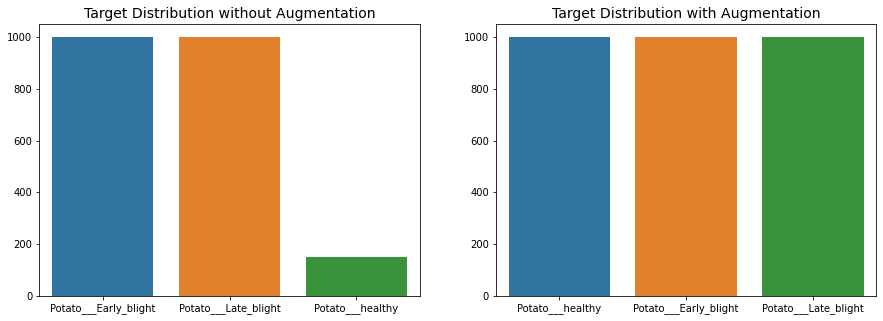

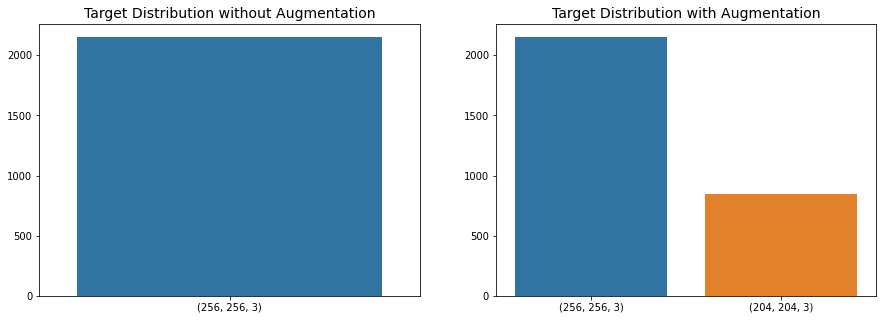

In [17]:
# target distribution visualize between original and augmented images
def distribution(counts_series_original, counts_series_augmented):
  fig = plt.figure(figsize=(15,5))
  fig.add_subplot(121)
  sns.barplot(x = counts_series_original.index, y = counts_series_original.values)
  plt.title('Target Distribution without Augmentation', fontsize=14)
  fig.add_subplot(122)
  sns.barplot(x = counts_series_augmented.index, y = counts_series_augmented.values)
  plt.title('Target Distribution with Augmentation', fontsize=14)

# returns pandas series with classes as keys and count as values for original dataset
target_counts_original = img_df_original['Label'].value_counts()

# returns pandas series with classes as keys and count as values for augmented dataset
target_counts_augmented = img_df_augmented['Label'].value_counts()

# shape analysis for original
shape_counts_original = img_df_original['Shape'].value_counts()

# shape analysis for augmented
shape_counts_augmented = img_df_augmented['Shape'].value_counts()

# visualize target distribution comparison
distribution(target_counts_original, target_counts_augmented)

# visualize shapes distribution comparison
distribution(shape_counts_original, shape_counts_augmented)

* **We can check the data is imbalanced, where very less Healthy image available**
* **All the images are of similar shapes for original datasets (256,256,3)**
* **For Augmented datasets total images are 3000, where each class contains 1000 samples.**
* **In augmented datasets some are of shape (256,256,3), and some are of shape (204,204,3).**

## Augmented Image Shapes EDA

Image shape comparison between different categories 

Shape          Label                
(256, 256, 3)  Potato___Late_blight     1000
               Potato___Early_blight    1000
(204, 204, 3)  Potato___healthy          848
(256, 256, 3)  Potato___healthy          152
dtype: int64



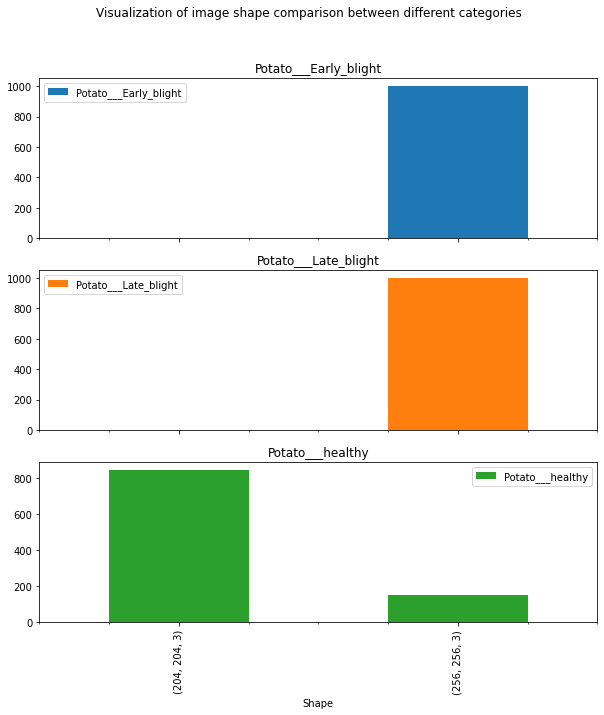

In [18]:
level_shape_df = img_df_augmented[['Shape', 'Label']].value_counts()
print(f'Image shape comparison between different categories \n\n{level_shape_df}\n')

# plotting the multi-index dataframe's hist() plot, where label, and shape are two index
level_shape_df.unstack(level = 1).plot(kind = 'bar', subplots = True, figsize = (10,10), 
                                       title = 'Visualization of image shape comparison between different categories')
plt.show()

**From the above analysis in Augmented dataset,**
* **"Potato_healthy" contains 152 samples which are similar size of (256,256,3) with the other two potato disease classes.**
* **848 samples of "Potato_healthy" category are of size (204,204,3)**
* **Thus, we need to resize them to a default shape (256,256,3)**

## Augmented images interpolation

Here one of the two common interpolation will be used 
1. Bi-linear spline interpolation
2. Bi-cubic spline interpolation

The comparison between these interpolations will be analyzed

Image index 1993
Augmented image shape before interpolation: (204, 204, 3)



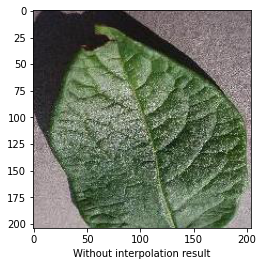

In [19]:
# random sample of augmented image of shape (204,204,3)
aug_img_indices = [sr for sr, img in enumerate(image_list_augmented) if img.shape == (204,204,3)]
a = random.choice(aug_img_indices)
print(f'Image index {a}')
img_a = image_list_augmented[a]
# sample augmented image of size (204,204,3) is used to compare the interpolations
print(f'Augmented image shape before interpolation: {img_a.shape}\n')
plt.imshow(np.array(img_a, dtype = np.float32)/255.0)
plt.xlabel('Without interpolation result')
plt.show()



Interpolation checks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


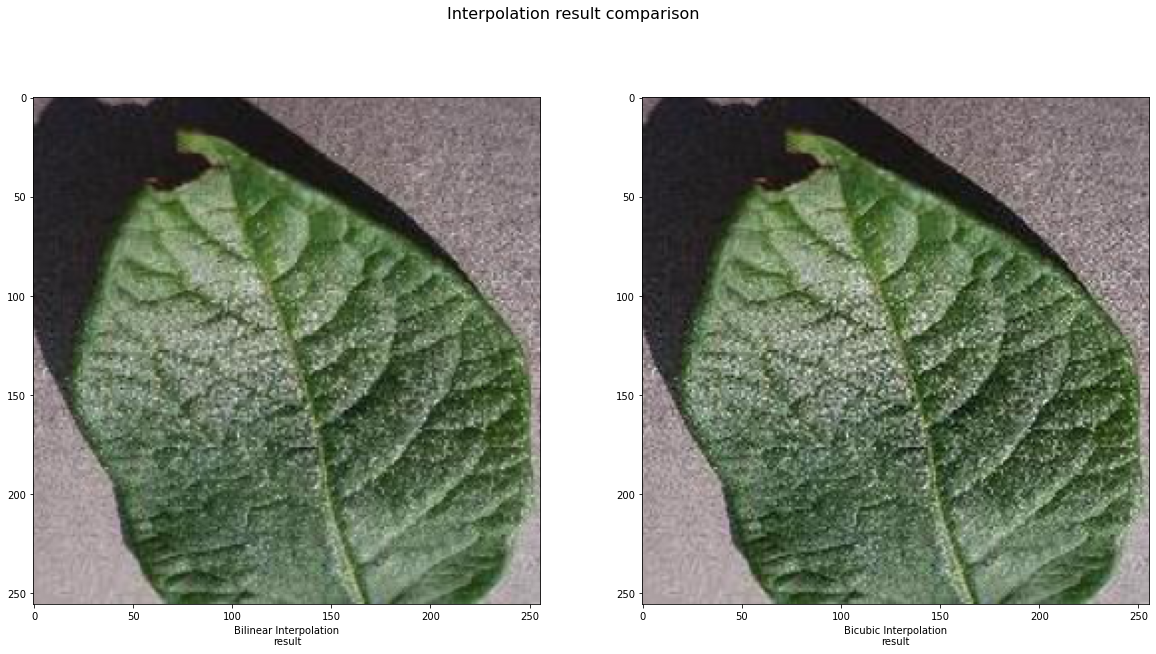

In [20]:
# applying bilinear spline interpolation
b1 = tf.keras.preprocessing.image.smart_resize(img_a, size=(256,256), interpolation='bilinear')
b1 = np.array(b1, dtype=np.float32)/255.0

# applying bicubic spline interpolation
b2 = tf.keras.preprocessing.image.smart_resize(img_a, size=(256,256), interpolation='bicubic')
b2 = np.array(b2, dtype=np.float32)/255.0

# visualize
fig = plt.figure(figsize = (20,10))
fig.suptitle('Interpolation result comparison', fontsize = 16)
fig.add_subplot(121)
plt.imshow(b1)
plt.xlabel('Bilinear Interpolation\nresult')
fig.add_subplot(122)
plt.xlabel('Bicubic Interpolation\nresult')
plt.imshow(b2)
plt.show()

Error: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[Reference](https://www.kaggle.com/c/ann-and-dl-image-segmentation/discussion/120550)

**Review:**
It is closely observed that, cubic spline resized a bit detailed or less blurry result, so finalizing "Bi-cubic spline interpolation", for resizing augmented image samples.


# Data Preparation

#### Resizing augmented images

Fetching augmented image index to be resized along with testing

In [21]:
print(f'Augmented datasets shape analysis: \n{shape_counts_augmented}')

Augmented datasets shape analysis: 
(256, 256, 3)    2152
(204, 204, 3)     848
Name: Shape, dtype: int64


In [22]:
# index list of augmented images
augment_index_list = [i for i, image in enumerate(image_list_augmented) if image.shape==(204, 204, 3)]

# test for index list fetching
if len(augment_index_list) == shape_counts_augmented.values[1]:
  print(f'Test passed, {len(augment_index_list)} Augmented images are there in the dataset to be resized ')
else:
  print('Check steps')  

Test passed, 848 Augmented images are there in the dataset to be resized 



**Resizing images**

In [23]:
default_image_size = (256,256)
for sr in augment_index_list:
  image_list_augmented[sr] = tf.keras.preprocessing.image.smart_resize(image_list_augmented[sr], 
                                                                       size=default_image_size, interpolation='bicubic')

# storing index having image shape (204,204,3) after interpolation
augment_index_list_resized1 = [i for i, image in enumerate(image_list_augmented) if image.shape==(204, 204, 3)]
augment_index_list_resized12 = [i for i, image in enumerate(image_list_augmented) if image.shape==(256, 256, 3)]

Testing interpolation step

In [24]:
# resize check
if len(augment_index_list_resized1) == 0 and len(augment_index_list_resized12) == len(image_list_augmented):
  print('Test passed, no images lef of size (204,204,3) in the list')
  print(f'All images have of equal shape (256,256,3) of size {len(image_list_augmented)}') 
else:
  print('Test failed, check implementation')

Test passed, no images lef of size (204,204,3) in the list
All images have of equal shape (256,256,3) of size 3000


## Transforming image labels

Defining one hot encodings for output labels 

In [25]:
# formatting the original dataset labels
image_labels_original = [potato_classifiers.index(label) for label in label_list_original] 

# formatting the augmented dataset labels
image_labels_augmented = [potato_classifiers.index(label) for label in label_list_augmented]

# sample image label

print(f'Sample formatted label: \n')
print(f'Label: {image_labels_original[0]}, class: {potato_classifiers[image_labels_original[0]]}')
print(f'Label: {image_labels_original[1000]}, class: {potato_classifiers[image_labels_original[1000]]}')
print(f'Label: {image_labels_original[2000]}, class: {potato_classifiers[image_labels_original[2000]]}')

Sample formatted label: 

Label: 0, class: Potato___Early_blight
Label: 1, class: Potato___healthy
Label: 2, class: Potato___Late_blight



## Converting images to numpy array and Normalizing

In [26]:
# numpy array for original image list
image_list_original = np.array(image_list_original, dtype = np.float32)/255.0

# numpy array for augmented image list
image_list_augmented = np.array(image_list_augmented, dtype = np.float32)/255.0

print(f'Shape of original np dataset {image_list_original.shape}')
print(f'Shape of augmented np dataset {image_list_augmented.shape}')

Shape of original np dataset (2152, 256, 256, 3)
Shape of augmented np dataset (3000, 256, 256, 3)


## Converting labels to numpy array

In [27]:
image_labels_original = np.array(image_labels_original, dtype=np.int32)
image_labels_augmented = np.array(image_labels_augmented, dtype=np.int32)
print(f'Shape of original labels {image_labels_original.shape}')
print(f'Shape of original labels {image_labels_augmented.shape}')

Shape of original labels (2152,)
Shape of original labels (3000,)


## Shuffle datasets and Visualization



Defining function to visualize

In [28]:
# here we are plotting 3 figures in a row
def visualize(image_list, label_list, title=None):
  fig = plt.figure(figsize = (10,5))
  fig.suptitle(title)
  for i in range(3):
    sr = i * 1000
    fig.add_subplot(1,3,i+1)
    plt.imshow(image_list[sr])
    plt.xlabel(potato_classifiers[label_list[sr]])


Shuffling original dataset and visualizing

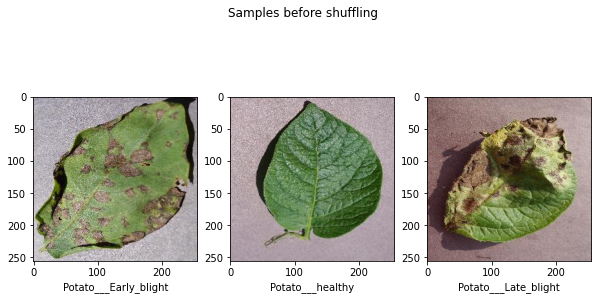

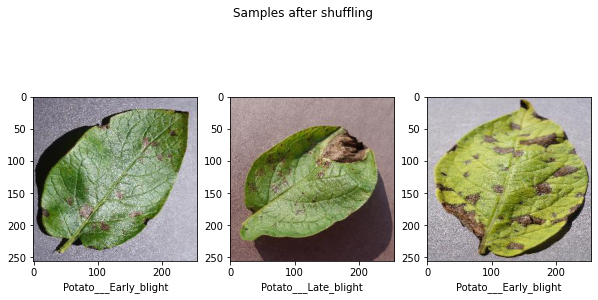

In [29]:
visualize(image_list_original, image_labels_original, title = 'Samples before shuffling')
# shuffling original dataset
image_list_original, image_labels_original = shuffle(image_list_original, image_labels_original)
visualize(image_list_original, image_labels_original, title = 'Samples after shuffling')

Shuffling augmented dataset and visualizing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


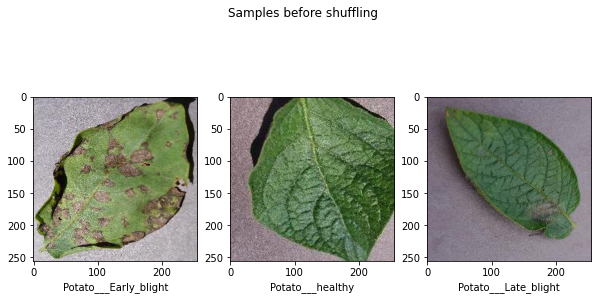

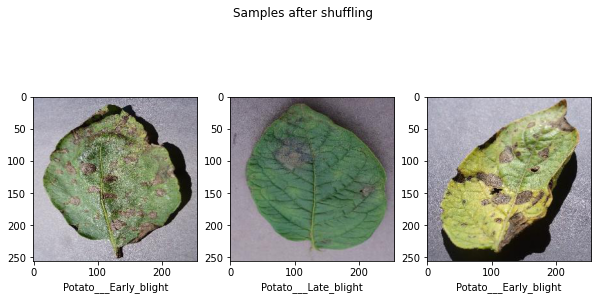

In [30]:
visualize(image_list_augmented, image_labels_augmented, title = 'Samples before shuffling')
# shuffling augmented dataset
image_list_augmented, image_labels_augmented = shuffle(image_list_augmented, image_labels_augmented)
visualize(image_list_augmented, image_labels_augmented, title = 'Samples after shuffling')

## Splitting the data into train and test set using "stratified  train_test_split"

**Splitting original data into  train and test split with test_size = 0.2**

In [31]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(image_list_original, image_labels_original, 
                                                                                        stratify = image_labels_original, test_size = 0.2, random_state = 42)



**Splitting augmented data into train and test split with test_size = 0.2**

In [32]:
x_train_augmented, x_test_augmented, y_train_augmented, y_test_augmented = train_test_split(image_list_augmented, image_labels_augmented,
                                                                                            stratify = image_labels_augmented, test_size = 0.2, random_state = 43)



## Summarize

In [33]:
print(f'Train shape for original data:\n{x_train_original.shape}, {y_train_original.shape}\n')
print(f'Test shape for original data:\n{x_test_original.shape}, {y_test_original.shape}\n')
print(f'Train shape for augmented data:\n{x_train_augmented.shape}, {y_train_augmented.shape}\n')
print(f'Test shape for augmented data:\n{x_test_augmented.shape}, {y_test_augmented.shape}\n')

# assertion checks
assert x_train_augmented.dtype == np.float32, x_train_original.dtype == np.float32
assert x_test_augmented.dtype == np.float32, x_test_original.dtype == np.float32
assert y_train_augmented.dtype == y_test_augmented.dtype == y_train_original.dtype == y_test_original.dtype == np.int32 
assert x_train_original.shape == (y_train_original.shape[0],256,256,3), x_train_augmented.shape == (y_train_augmented.shape[0], 256, 3) 
assert x_test_original.shape == (y_test_original.shape[0],256,256,3), x_test_augmented.shape == (y_test_augmented.shape[0], 256, 3) 
# stratified split check
assert round(len(x_train_original) / len(x_test_original)) == 4, round(len(x_train_augmented) / len(x_test_augmented)) == 4 
assert len(y_train_original.shape) == len(y_test_original.shape) == len(y_train_augmented.shape) == len(y_test_augmented.shape)
print('All assertion checks are done successfully')

Train shape for original data:
(1721, 256, 256, 3), (1721,)

Test shape for original data:
(431, 256, 256, 3), (431,)

Train shape for augmented data:
(2400, 256, 256, 3), (2400,)

Test shape for augmented data:
(600, 256, 256, 3), (600,)

All assertion checks are done successfully


## Train and Test distribution of diffferent classes in the stratified splits

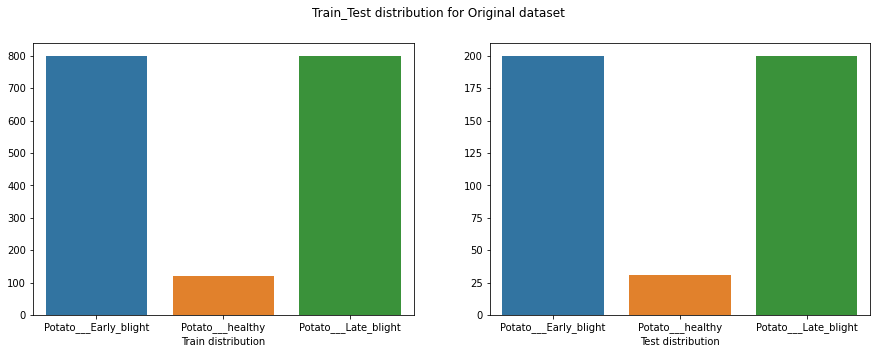

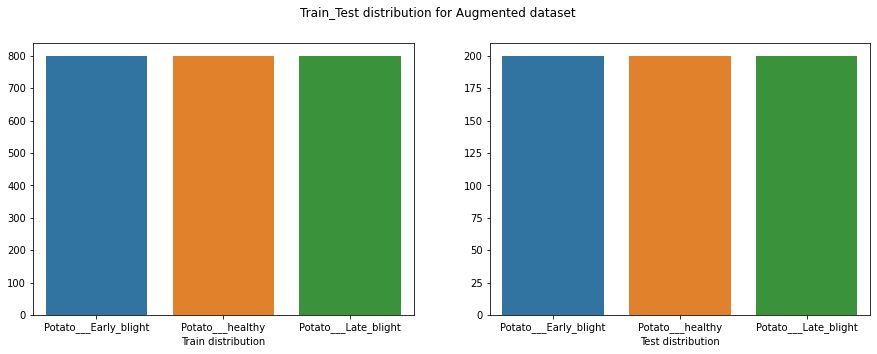

In [34]:
def train_test_distribution(y_train, y_test, label):
  class_count = [[list(y_train).count(i) for i,_ in enumerate(potato_classifiers)],
  [list(y_test).count(i) for i,_ in enumerate(potato_classifiers)]]
  fig = plt.figure(figsize=(15,5))
  labels = ['Train distribution', 'Test distribution']
  fig.suptitle(f'Train_Test distribution for {label} dataset')
  for i in range(2):
    fig.add_subplot(1,2,i+1)
    g = sns.barplot(x=potato_classifiers, y = class_count[i]) 
    # display peak values on bar plot, create dataframe to do so
    #g.text(potato_classifiers[0], 800,1, color = 'black', ha = 'center')
    plt.xlabel(labels[i])
  

# distribution study for original dataset
train_test_distribution(y_train_original, y_test_original, label='Original')

# distribution study for augmented dataset
train_test_distribution(y_train_augmented, y_test_augmented, label='Augmented')

**Note: The above plots gives the validation of perfect stratified splits**

# CNN Model Building 

## Model 1

Here we are implementing custom models of the following paper along with additional hyperparameter tuning and testing

[Comparative Assessment of Deep Learning to Detect the Leaf Diseases of Potato based on Data Augmentation](https://ieeexplore.ieee.org/abstract/document/9200015)

In [35]:
# input image shape = (256,256,3)
input_shape = x_train_original[0].shape
# num_classes = 3
num_classes = len(potato_classifiers)
print(f'Model input_shape {input_shape}')
print(f'Number of output class {num_classes}')

Model input_shape (256, 256, 3)
Number of output class 3


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               157451

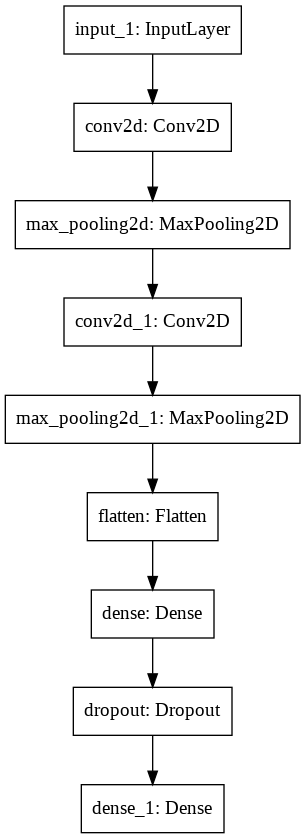

In [59]:
def model(input_shape, num_classes):
  inputs = keras.layers.Input(shape = input_shape)

  x = keras.layers.Conv2D(filters = 16, kernel_size=3, activation='relu', strides=1)(inputs)
  x = keras.layers.MaxPooling2D(pool_size=(2,2), strides = 2)(x)
  x = keras.layers.Conv2D(filters = 32, kernel_size=3, activation='relu', strides=1)(x)
  x = keras.layers.MaxPooling2D(pool_size=(2,2), strides = 2)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(rate = 0.3)(x)
  output = keras.layers.Dense(num_classes, activation='softmax')(x)

  return keras.models.Model(inputs = inputs, outputs = output)

model = model(input_shape, num_classes)
model.summary()
# save model structure image
plot_model(model, to_file = 'potato_cnn.png')

# Model Training

#### Defining Hyperparameters and Metadata 

In [60]:
# recommended in the paper
learning_rate = 0.001
epochs = 10
batch_size = 32
loss_fn = 'sparse_categorical_crossentropy'

## Configuring wandb to initialize and log training

In [61]:
# initialize wandb with the project

run = wandb.init(project='Potato_disease_classifier',
                 config = {
                     "learning_rate": learning_rate,
                     "epochs": epochs,
                     "batch_size": batch_size,
                     "loss_function": loss_fn,
                     "architecture": "CNN", 
                     "dataset":"Plant Village"
                 })

config = wandb.config # will be used to configure the experiment

# clearing session
keras.backend.clear_session()

# defining the optimizer 
optimizer = Adam(lr = 0.001)
model.compile(optimizer=optimizer, loss = loss_fn, metrics = ['acc'])

Defining callbacks

In [75]:
# creating model directory to save model details
if not os.path.isdir('Model'):
  os.mkdir('Model')

# model checkpoint original
filepath_original = 'Potato_original_epoch{epoch:02d}-loss {val_acc:0.2f}.hdf5'
mc_original = ModelCheckpoint(filepath = filepath_original, monitor='val_acc', save_weights_only=True,mode = 'max', verbose = 1)

# model checkpoint augmented
filepath_augmented = 'Potato_augmented_epoch{epoch:02d}-loss {val_acc:0.2f}.hdf5'
mc_augmented = ModelCheckpoint(filepath=filepath_augmented, monitor='val_acc', save_weights_only=True,mode = 'max', verbose = 1)

## Training the Model with original dataset

Model training and visualizing with livelossplot

In [76]:
# clearing session
keras.backend.clear_session()

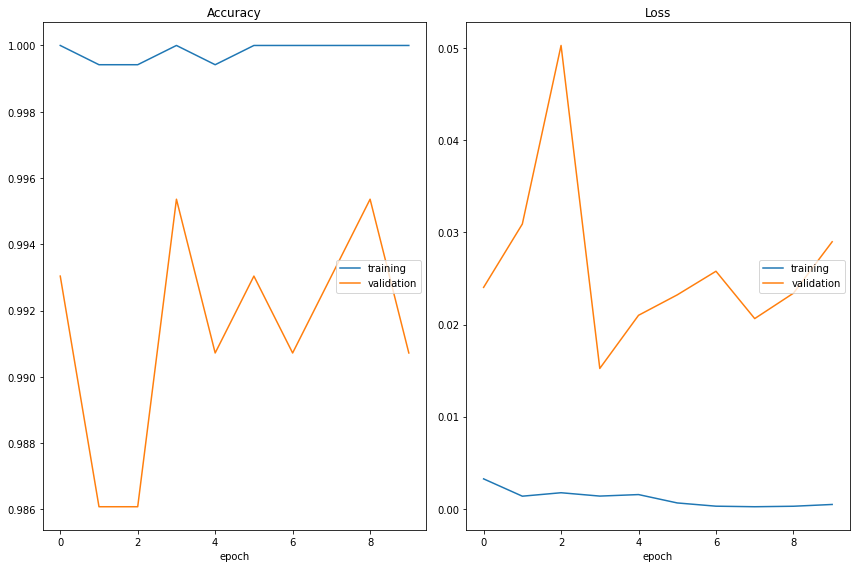

Accuracy
	training         	 (min:    0.999, max:    1.000, cur:    1.000)
	validation       	 (min:    0.986, max:    0.995, cur:    0.991)
Loss
	training         	 (min:    0.000, max:    0.003, cur:    0.000)
	validation       	 (min:    0.015, max:    0.050, cur:    0.029)

Epoch 00010: saving model to Potato_original_epoch10-loss 0.99.hdf5


In [77]:
history_original = model.fit(x = x_train_original, y = y_train_original, batch_size = batch_size, epochs = epochs, validation_data=(x_test_original, y_test_original), 
               verbose = 1, callbacks = [PlotLossesKeras(), mc_original])
#, callbacks = [PlotLossesCallback(), tbcallback])
#, callbacks = [WandbCallback()])

Load weights of best model and evaluate

In [78]:
weights_file_org = '/content/Potato_original_epoch09-loss 1.00.hdf5'
model.load_weights(weights_file)
evaluate_org = model.evaluate(x_test_original, y_test_original)
print('Model evaluation trained on original dataset\n')
print(f'Original Test Loss: {evaluate_org[0]}, Accuracy: {evaluate_org[1]}')

14/14 [==============================] - 1s 40ms/step - loss: 0.0234 - acc: 0.9954
Model evaluation trained on original dataset

Original Test Loss: 0.023408040404319763, Accuracy: 0.9953595995903015


## Training the Model with augmented dataset

Model training and visualizing with livelossplot

In [81]:
# clearing session
keras.backend.clear_session()

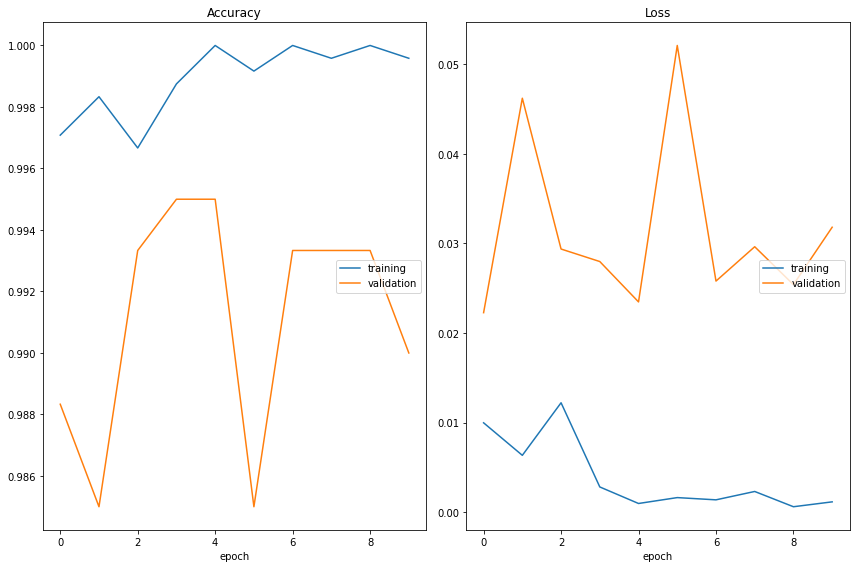

Accuracy
	training         	 (min:    0.997, max:    1.000, cur:    1.000)
	validation       	 (min:    0.985, max:    0.995, cur:    0.990)
Loss
	training         	 (min:    0.001, max:    0.012, cur:    0.001)
	validation       	 (min:    0.022, max:    0.052, cur:    0.032)

Epoch 00010: saving model to Potato_augmented_epoch10-loss 0.99.hdf5


In [83]:
history = model.fit(x = x_train_augmented, y = y_train_augmented, batch_size=batch_size, epochs = epochs, verbose = 1,
        validation_data=(x_test_augmented, y_test_augmented), callbacks = [PlotLossesKeras(), mc_augmented, WandbCallback()])

In [80]:
weights_file_aug = '/content/Potato_original_epoch09-loss 1.00.hdf5'
model.load_weights(weights_file_aug)
evaluate_aug = model.evaluate(x_test_augmented, y_test_augmented)
print('Model evaluation trained on augmented dataset\n')
print(f'Augmented Test Loss: {evaluate_aug[0]}, Accuracy: {evaluate_aug[1]}')

19/19 [==============================] - 1s 38ms/step - loss: 0.0493 - acc: 0.9883
Model evaluation trained on augmented dataset

Augmented Test Loss: 0.04929576441645622, Accuracy: 0.9883333444595337
